# image classification *with pytorch*
+ DNN
+ CNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(42)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Define Model
+ DNN: three layers (500, 1000, 10).
+ CNN: four layers (2 convolutional and two fully connected)

In [3]:
class DNN(nn.Module):
  def __init__(self):
    super(DNN, self).__init__() # 자식클래스가 상속받는 부모 클래스를 불러옴
    self.fc1 = nn.Linear(784, 500)  # input = 28 * 28 * 1 = 784
    self.fc2 = nn.Linear(500, 1000)
    self.fc3 = nn.Linear(1000, 10)  # output = 10 (라벨 개수)

  def forward(self, x):
    x = x.view(-1, 784) # flatten: 1차원
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) # classification의 출력층이므로 relu X
    return F.log_softmax(x, dim=1)

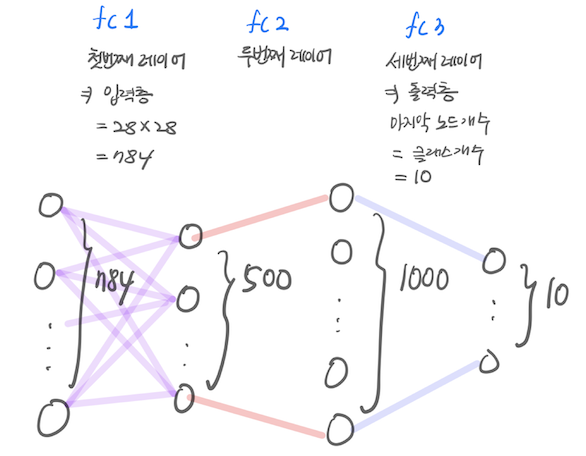

In [4]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 20, 5)  # input channel, ouput channel, kernel
    self.conv2 = nn.Conv2d(20, 50, 5)
    self.fc1 = nn.Linear(4*4*50, 500)  # input 아님. 계산하기
    self.fc2 = nn.Linear(500, 10)  # output = 10 (라벨 개수)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4 * 4 * 50)
    x = F.relu(self.fc1(x))
    x = self.fc2(x) # classification의 출력층이므로 relu X
    return F.log_softmax(x, dim=1)

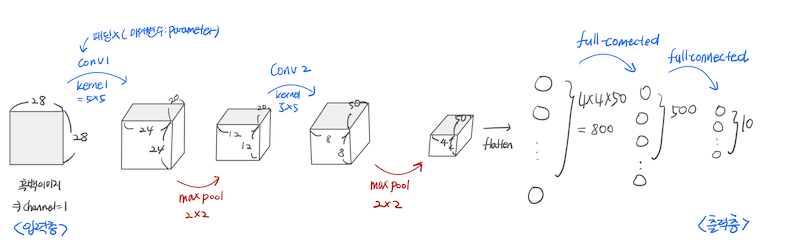

## Loading data
We use DataLoader and DataSet toch util classes.

#### 훈련 데이터, 테스트 데이터 분리 (일반화)

+ train_test_split()

  ```
  from sklearn.model_selection import train_test_split

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

  X_train = torch.Tensor(X_train)
  X_test = torch.Tensor(X_test)
  y_train = torch.LongTensor(y_train)
  y_test = torch.LongTensor(y_test)

  ds_train = TensorDataset(X_train, y_train)
  ds_test = TensorDataset(X_test, y_test)

  loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
  loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

  ```





#### 훈련 데이터, 테스트 데이터 분리 - [MNIST](https://bcho.tistory.com/1154)

+ Normalize 클래스: 다차원 텐서를 지원하고, 튜플 타입으로 avg, std값을 입력받음.
  1. 튜플: 원소가 1개인 튜플을 정의하기 위해서 괄호 안에 콤마를 적어야 함. 아니면 숫자 타입으로 인식될 수 있음.

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(), # 이미지를 PyTorch Tensor로 변환
                       transforms.Normalize((0.1307,), (0.3081,)) # MNIST 데이터 세트의 평균 및 표준편차
                   ])),
                   batch_size=128, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                       ])),
                       batch_size=1000, shuffle=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [6]:
print(len(train_loader))
print(test_loader.dataset.data[3848].shape)

469
torch.Size([28, 28])


#### Issue
Normalize 결과 avg=0, std=1이 아닌 것 같음

(Normalize의 이해 부족? - 추가 공부 중)

+ transforms
  1. [참고](https://tutorials.pytorch.kr/beginner/basics/transforms_tutorial.html)
  2. [참고](https://wikidocs.net/157285)
+ Normalize
  1. [참고](https://www.binarystudy.com/2021/09/how-to-normalize-pytorch-tensor-to-0-mean-and-1-variance.html)
  2. [참고](https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/)

In [7]:
# FIXME: transforms.Normalize(mean, std)
# 결과를 보면 설명들과 다름. 평균이 0이 되지 못함
print(train_loader.dataset.data[3848])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  49, 125, 168, 255, 254, 187,
         157,  35,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 158, 253, 253, 253, 253, 253,
         253, 249, 224, 100,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  62,  96,  12,  12,  12, 113,
         142, 165, 253, 251, 225,  43,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

## Training and Testing Loops
Boilerplate code for training and testing (almost never changes).

+ zero_grad

```
optimizer.zero_grad() # 경사를 0으로 초기화 ..?
```


w가 아닌 gradient를 0으로 초기화한다는 것! [참고](https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%EA%B8%B0%EC%B4%88-modelzerograd-optimizerzerograd-%EC%93%B0%EB%8A%94-%EC%9D%B4%EC%9C%A0)

  다음 루프를 돌 때, 이전에 학습한 gradient가 남아 있음. 0으로 초기화한 후, 해당 학습을 시작
  
  [참고1](https://algopoolja.tistory.com/55), [참고2](https://velog.io/@kjb0531/zerograd%EC%9D%98-%EC%9D%B4%ED%95%B4), [참고3](https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%EA%B8%B0%EC%B4%88-modelzerograd-optimizerzerograd-%EC%93%B0%EB%8A%94-%EC%9D%B4%EC%9C%A0)

  

In [8]:
def train(model, device, train_loader, loss_func, optimizer, epoch):
  model.train() # 신경망을 학습 모드로 전환
  # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() # 경사를 0으로 초기화
    output = model(data)  # 데이터를 입력하고 출력을 계산
    # 역전파
    loss = loss_func(output, target)  # 출력과 훈련 데이터 정답 간의 오차를 계산 # loss = F.nll_loss(output, target)
    loss.backward() # 오차를 역전파 계산
    optimizer.step()  # 역전파 계산한 값으로 가중치를 수정
    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, loss_func):
  model.eval()  # 신경망을 추론 모드로 전환
  test_loss = 0
  correct = 0
  # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
  with torch.no_grad(): # 추론 과정에는 미분이 필요없음
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)  # 데이터를 입력하고 출력을 계산
      # 역전파
      test_loss += loss_func(output, target).sum().item() # sum up batch loss # test_loss += F.nll_loss(output, target, reduction='sum').item() # origianl: sum up batch loss
      pred = output.argmax(dim=1, keepdim=True) # get the index of the max log.probability # 확률이 가장 높은 레이블이 무엇인지 계산
      correct += pred.eq(target.view_as(pred)).sum().item() # 정답과 일치한 경우 정답 카운트를 증가
  test_loss /= len(test_loader.dataset)

# 정확도 출력
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

## Final parameter tuning and training

+ loss function

  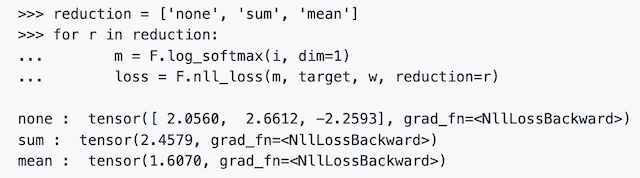

+ CrossEntorpyLoss vs l2-norm Loss [참고](https://velog.io/@skyhelper/CrossEntorpyLoss-NLLLoss-%EB%AC%B4%EC%97%87%EC%9D%B4-%EB%8B%A4%EB%A5%B8%EA%B0%80)

  + 둘 다 cross-entropy를 구함
  + CrossEntropyLoss = LogSoftmax + NLLLoss => softmax 적용 후 손실 값 구함. 모델에는 softmax가 없음
  + NllLoss => 모델 마지막 레이어에 softmax 있음

In [9]:
for model_type in [DNN, CNN]:
  model = model_type().to(device) # model = DNN().to(device)
  print(("=" * 50) + '\n' + ("=" * 50))
  print(type(model).__name__)
  # 오차함수 선택
  loss_func = F.nll_loss  # 파이썬은 함수도 변수로 전달할 수 있음
  # 가중치를 학습하기 위한 최적화 기법 선택
  optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)

  # Test before training
  test(model, device, test_loader, loss_func)
  for epoch in range(1, 3 + 1):
    train(model, device, train_loader, loss_func, optimizer, epoch)
    test(model, device, test_loader, loss_func)

  torch.save(model.state_dict(), "mnist_" + type(model).__name__ + ".pt")

DNN

Test set: Average loss: 0.0023, Accuracy: 1131/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292511
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.369876
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.172832
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.314808
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.264657

Test set: Average loss: 0.0002, Accuracy: 9535/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.109845
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.115719
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.077633
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.093020
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.110912

Test set: Average loss: 0.0001, Accuracy: 9651/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.153664
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.104682
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.090070
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.085719
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.083587

Test set: Average loss: 0.0001, Accuracy: 9730/10000 (97%)

CNN

Test set: Av

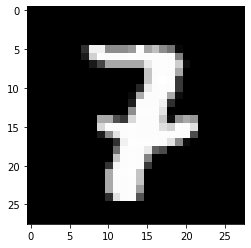

In [14]:
import matplotlib.pyplot as plt
test_image = test_loader.dataset.data[3848]     # 3848, 7766, 1000
plt.imshow(test_image, cmap='gray')

In [15]:
for model_type in [DNN, CNN]:
  model = model_type().to(device)
  print(("=" * 50) + '\n' + ("=" * 50))
  print(type(model).__name__)
  model.load_state_dict(torch.load("mnist_" + type(model).__name__ + ".pt"))
  model.eval()
  
  if model_type == CNN:
    out = model(test_image.view(1, 1, 28, 28).float().cuda())
  else:
    out = model(test_image.float().cuda())
  print(out)
  print(out.argmax(dim=1))

DNN
tensor([[ -858.8292,  -645.0271,  -367.9324,  -193.3340,  -936.9427, -1171.7522,
         -1268.1255,     0.0000,  -741.9819,  -775.8269]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
tensor([7], device='cuda:0')
CNN
tensor([[-1472.9772, -1156.3087,  -849.3556,  -791.0173, -1291.4095, -1802.6227,
         -2063.3694,     0.0000,  -971.7689, -1507.1687]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
tensor([7], device='cuda:0')


### Report

+ 네트워크에 따라 예측값이 다른 경우

  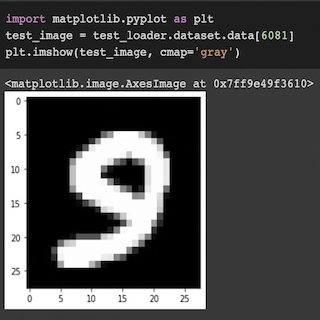

  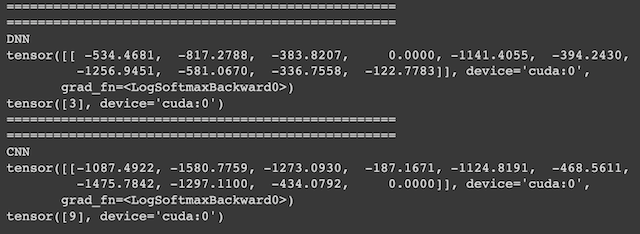

## EXTRA)

In [12]:
import torchvision
dir(torchvision.models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [13]:
dir(F)

['BroadcastingList1',
 'BroadcastingList2',
 'BroadcastingList3',
 'Callable',
 'DType',
 'GRID_SAMPLE_INTERPOLATION_MODES',
 'GRID_SAMPLE_PADDING_MODES',
 'List',
 'Optional',
 'TYPE_CHECKING',
 'Tensor',
 'Tuple',
 'Union',
 '_Reduction',
 '_VF',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_adaptive_max_pool1d',
 '_adaptive_max_pool2d',
 '_adaptive_max_pool3d',
 '_add_docstr',
 '_fractional_max_pool2d',
 '_fractional_max_pool3d',
 '_get_softmax_dim',
 '_in_projection',
 '_in_projection_packed',
 '_infer_size',
 '_list_with_default',
 '_max_pool1d',
 '_max_pool2d',
 '_max_pool3d',
 '_mha_shape_check',
 '_no_grad_embedding_renorm_',
 '_overload',
 '_pair',
 '_scaled_dot_product_attention',
 '_single',
 '_threshold',
 '_triple',
 '_unpool_output_size',
 '_verify_batch_size',
 '_verify_spatial_size',
 'adaptive_avg_pool1d',
 'adaptive_avg_pool2d',
 'adaptive_avg_pool3d',
 'adaptive_max_pool1d',
 'adaptive_max_pool1d_

+ 참고자료
  1. Introduction to Convolutional Neural Networks: With Image Classfication Using Pytorch
  2. https://wikidocs.net/book/2788

+ 앞으로 참고할 자료
  1. [모두의 딥러닝](https://www.youtube.com/watch?v=7eldOrjQVi0&list=PLQ28Nx3M4JrhkqBVIXg-i5_CVVoS1UzAv&index=1)